# **Lab DL 07: Analisa Sentimen Menggunakan GRU**
Nama : Muhammad Fikrizza

NIM  : 2000018096

# **1. Pendahuluan**
**Analisa Sentimen** (*sentiment analysis*) pada dasarnya adalah *task* klasifikasi yang memetakan sebuah kalimat (opini) ke dalam dua golongan/ kelas, yaitu:
1. Opini positif (*positive opinion*)
2. Opini negatif (*negative opinion*)

Ada pula yang menambahkan satu golongan lagi yaitu Opini netral (*neutral opinion*)

Analisa sentimen biasa dilakukan pada data-data yang diperoleh dari media sosial, untuk mempelajari opini publik terhadap suatu hal yang dianggap penting. Data dari Twitter merupakan data media sosial yang kerap digunakan untuk melakukan analisa sentimen karena data twitter terbuka dan mudah untuk di-scrapping (diambil). 



**Tujuan Praktikum:**
Menggunakan Gated Recurrent Unit (GRU) untuk melakukan analisa sentimen pada Teks Twitter, yaitu memetakan teks Twit ke dalam kelas Positive, Negative, atau Netral.



**Data:** Sentiment.csv
Data yang akan digunakan pada praktikum ini merupakan data *First GOP Debate Twitter Sentiment* yaitu dataset berisi Twit (pesan kicauan di Twitter) berkaitan dengan Debat Pemilihan Presiden di United States (US) pada tahun 2016. Dataset terdiri dari 13871 data Twit. Dataset memiliki 21 fitur. Pada praktikum ini, hanya fitur 'text' yang akan digunakan dan targetnya adalah 'Positive', 'Negative', serta 'Neutral' 


Gated Recurrent Unit (GRU) merupakan salah satu bentuk Recurrent Neural Network (RNN). GRU merupakan salah satu varian dari Long Short Term Memory (LSTM).
Teori tentang Gated Recurrent Unit (GRU) dapat dilihat pada  [link berikut](https://indoml.com/2018/04/13/pengenalan-long-short-term-memory-lstm-dan-gated-recurrent-unit-gru-rnn-bagian-2/)


# **2. Mounting Google Drive**

In [1]:
from google.colab import drive

# mounting dataset dari gdrive
drive.mount('/content/gdrive', force_remount=True)

# lokasi dataset - ubah sesuai dengan lokasi anda mengupload folder datanya
root_path = 'gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Pertemuan 7/'

# opsional - tampilkan info lokasi dataset
print("Path root:", root_path)

Mounted at /content/gdrive
Path root: gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Pertemuan 7/


# **3**. **Import Library yang Akan Digunakan**

In [2]:
# import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, TimeDistributed
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils.np_utils import to_categorical
import re
from numpy import array

# **4. Baca Dataset** 
Load data dari file "Sentiment.csv"

In [3]:
df = pd.read_csv(root_path + "Sentiment.csv")

## **4.1. Tampilkan Fitur**
Tampilkan semua fitur dalam dataset Sentiment

In [4]:
print(df.columns)

Index(['id', 'candidate', 'candidate_confidence', 'relevant_yn',
       'relevant_yn_confidence', 'sentiment', 'sentiment_confidence',
       'subject_matter', 'subject_matter_confidence', 'candidate_gold', 'name',
       'relevant_yn_gold', 'retweet_count', 'sentiment_gold',
       'subject_matter_gold', 'text', 'tweet_coord', 'tweet_created',
       'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')


## **4.2. Pilih Fitur (Feature Selection)**
Hanya fitur Text dan Sentiment yang akan digunakan. Text berisi teks cuitan pada Twitter. Sedangkan fitur Sentiment menunjukkan kelas Sentiment (Positive, Negative, atau Neutral)

In [5]:
# fitur yang akan digunakan hanya fitur 'text' dan fitur 'sentiment' sebagai target
data = df[['text','sentiment']]

print(data.text)
print(data.sentiment)


0        RT @NancyLeeGrahn: How did everyone feel about...
1        RT @ScottWalker: Didn't catch the full #GOPdeb...
2        RT @TJMShow: No mention of Tamir Rice and the ...
3        RT @RobGeorge: That Carly Fiorina is trending ...
4        RT @DanScavino: #GOPDebate w/ @realDonaldTrump...
                               ...                        
13866    RT @cappy_yarbrough: Love to see men who will ...
13867    RT @georgehenryw: Who thought Huckabee exceede...
13868    RT @Lrihendry: #TedCruz As President, I will a...
13869    RT @JRehling: #GOPDebate Donald Trump says tha...
13870    RT @Lrihendry: #TedCruz headed into the Presid...
Name: text, Length: 13871, dtype: object
0         Neutral
1        Positive
2         Neutral
3        Positive
4        Positive
           ...   
13866    Negative
13867    Positive
13868    Positive
13869    Negative
13870    Positive
Name: sentiment, Length: 13871, dtype: object


# **5. Preprocessing Teks**


## 5.1. Mengubah teks ke huruf kecil
Lakukan preprocessing pada pesan Twit, yaitu dengan mengubah semua huruf menjadi huruf kecil 

In [6]:
# Preprocessing data Twit
data['text'] = data['text'].str.lower() #mengubah ke dalam huruf kecil semua
print(data['text'])

0        rt @nancyleegrahn: how did everyone feel about...
1        rt @scottwalker: didn't catch the full #gopdeb...
2        rt @tjmshow: no mention of tamir rice and the ...
3        rt @robgeorge: that carly fiorina is trending ...
4        rt @danscavino: #gopdebate w/ @realdonaldtrump...
                               ...                        
13866    rt @cappy_yarbrough: love to see men who will ...
13867    rt @georgehenryw: who thought huckabee exceede...
13868    rt @lrihendry: #tedcruz as president, i will a...
13869    rt @jrehling: #gopdebate donald trump says tha...
13870    rt @lrihendry: #tedcruz headed into the presid...
Name: text, Length: 13871, dtype: object


<ipython-input-6-445803958d85>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].str.lower() #mengubah ke dalam huruf kecil semua


## 5.2. Tokenisasi
Lakukan preprocessing Tokenisasi

In [7]:
#memisahkan setiap kalimat menjadi token (kata) dengan menggunakan kelas Tokenize dari Keras
#asumsi jumlah kata maksimal yang dikenali adalah 10000
# kelas Tokenizer akan otomatis menghilangkan tanda baca dalam kalimat
tokenizer = Tokenizer(num_words=10000, split=' ')
tokenizer.fit_on_texts(data['text'].values)

#Mengubah setiap kalimat Twit menjadi list of words, kemudian menghitung frekuensi setiap kata dan menghasilkan frekuensi dari setiap kata.
#Hanya akan mengenali num_words-1 kata dengan frekuensi tertinggi (dalam hal ini 9999 kata). 
#Hanya akan mengambil kata-kata yang dikenali (dalam hal ini kata dalam bahasa inggris saja).
X = tokenizer.texts_to_sequences(data['text'])
print(X)
#setiap kalimat memiliki jumlah kata yang berbeda, sehingga panjang list berbeda-beda
#cek panjang list of words dari setiap kalimat
for i in range(0, len(X)):
  print(len(X[i]))

#pad_sequence menyamakan ukuran dari setiap list of words. Karena setiap kalimat jumlah katanya berbeda-beda maka dilakukan padding
#tujuan padding adalah untuk menyamakan panjang list of words.  List of words yang lebih sedikit ukurannya akan ditambahkan dengan 0 sehingga panjang list semua seragam (ambil panjang terbesar)
X = pad_sequences(X)
print (X)

Streaming output truncated to the last 5000 lines.
19
13
25
19
7
19
19
20
25
10
19
20
19
13
13
19
13
20
16
16
19
20
13
19
15
27
20
19
17
13
20
18
20
19
20
19
20
20
25
19
16
15
7
16
18
20
21
20
18
20
20
25
13
8
18
17
19
19
19
19
9
23
9
25
20
19
15
23
11
21
18
22
20
18
18
13
19
19
13
20
15
19
13
19
21
20
19
21
15
19
23
19
18
25
13
20
18
13
22
19
25
21
20
22
13
25
21
22
20
14
19
22
24
25
20
21
19
22
19
11
19
25
22
20
8
19
20
22
20
19
10
15
19
13
17
13
25
13
19
24
16
19
13
19
22
19
20
19
19
19
19
23
19
18
22
23
19
19
19
20
22
20
19
20
19
20
20
20
21
18
13
22
19
19
19
23
13
19
20
10
17
14
21
11
20
21
13
15
18
18
13
19
16
13
7
8
15
20
21
20
22
15
13
19
9
20
16
17
19
21
19
24
15
26
19
18
19
19
18
9
11
16
21
19
20
19
13
19
17
20
20
19
20
20
18
19
19
20
18
19
19
20
19
14
20
17
19
19
19
19
13
24
13
19
19
19
20
15
19
20
19
16
19
19
19
20
22
20
19
20
18
22
20
12
19
19
19
19
18
19
19
18
19
20
19
19
19
20
17
8
20
18
19
11
9
19
19
19
19
20
21
19
12
19
19
24
19
10
14
20
15
22
20
15
19
19
19
19
19
22
1

## 5.3. Rekonstruksi dimensi fitur
Ubah bentuk X menjadi 3 dimensi karena input dari GRU harus berbentuk 3 dimensi. Kemudian nilai-nilai pada X diubah menjadi float karena supaya compatible (cocok) pada operasi matematika di GRU.

In [8]:
#karena input dari GRU mengharus 3 dimensi maka X harus direshape
X = X.reshape(X.shape[0],X.shape[1],1)
print(X.shape)
X = array(X)
X = X.astype(np.float32)

(13871, 31, 1)


## 5.4. Konversi fitur ke categorical
Ubah fitur target yang bernilai kategorikal (Positive, Negative, dan Neutral) menjadi angka menggunakan LabelEnocoder. Karena ada 3 kelas maka nilainya akan berubah menjadi 0,1,dan 2.

In [9]:
#mengubah fitur target (kelas) menjadi angka (asalnya masih string Positive, Negative, dan Netral)
from sklearn.preprocessing import LabelEncoder

Le = LabelEncoder()
y = Le.fit_transform(data['sentiment'])
y = array(y)
y = y.astype(np.float32)
print(y)
print(Le.classes_)

[1. 2. 1. ... 2. 0. 2.]
['Negative' 'Neutral' 'Positive']


## 5.5. Konversi ke One-hot Encoding
Mengubah fitur target yang masih berupa angka, menjadi one hot encoding. Hal ini diperlukan untuk menentukan luaran/output dari model Deep Learning.

In [10]:
#y yang berisi nilai 0,1,2 yang merepresentasikan Negative, Neutral dan Positive
# nilai y perlu diubah menjadi one-hot-encoding 

onehot_encoder = OneHotEncoder(sparse=False)
y = y.reshape(len(y), 1)
onehot_y = onehot_encoder.fit_transform(y)
print(onehot_y)


[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# **6. Membangun Model Deep Learning**

In [11]:
# #arsitektur model Deep Learning
# gru_hidden = 20
# model = Sequential()
# model.add(GRU(gru_hidden))
# model.add(Dense(3, activation='softmax'))
# model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])


# **7. Split Dataset**
Membagi data untuk training dan testing

In [12]:
# #menbagi data menjadi training dan testing
# X_train, X_test, y_train, y_test = train_test_split(X,onehot_y, test_size = 0.3, random_state = 42)


# **8. Training Model GRU**
Melakukan Training

In [13]:
# #training
# history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32)

NameError: ignored

## Melihat Statistik Pelatihan
Melihat performa training dari Kurva Loss

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

Apabila dilihat dari Kurva Loss di atas, maka model yang kita bangun masih bersifat "overfitting" sebab nilai Loss pada validation set (orange) masih lebih besar (tinggi) dari nilai Loss pada training set (biru). Oleh karena itu, model masih perlu diperbaiki supaya garis biru dan orange berhimpit (model ideal), yang artinya nilai Loss pada validation set dan training set tidak berbeda (hampir sama)

# **9. Evaluasi Performa Model**
Melakukan tes, melihat akurasi hasil prediksi pada data test

In [ ]:
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

# **10. Evaluasi Data Test**
Coba kalian generate Confusion Matrix dari prediksi data test (menggunakan cara yang sudah diajarkan dari praktikum sebelumnya), dan perhatikan kelas mana yang masih kecil nilai True Positive nya. 

In [ ]:
print(history)

In [ ]:
# import itertools
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix

# confusion_matrix(y_train, y_test)
# print('Laporan Klasifikasi Data Uji :')
# print(classification_report(history.history['loss'], history.history['accuracy']))

## **POST TEST**

Hasil akurasi pada Data Test yang kita peroleh masih di bawah 70% yaitu 67% dan model yang dibangun masih "Overfitting". Tingkatkan akurasi tersebut dengan mencoba beberapa hal di bawah ini:
1. Naikkan nilai gru_hidden (jumlah hidden layer pada GRU)
2. Coba train_test_split 60:40
3. Coba validation_split: 0.3 atau 0.4
4. Ubah parameter2 lain yang mungkin bisa meningkatkan akurasi prediksi sentimen analisis ini.
5. Menambah arsitektur model, misalnya GRU dibuat 2 layer, Dense juga dibuat 2 Layer
6. Jika kalian sudah mempelajari Natural Language Processing (NLP) lakukan preprocessing tambahan yaitu menghilangkan stopword, dan mencari nilai tf idf dari setiap kata. 


In [14]:
#menbagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X,onehot_y, test_size = 0.4, random_state = 42)

In [35]:
#arsitektur model Deep Learning
gru_hidden = 30
model = Sequential()
model.add(GRU(gru_hidden))
model.add(Dense(6, activation='softmax'))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])


In [37]:
#training
history = model.fit(X_train, y_train, validation_split=0.4, epochs=10, batch_size=32)

Epoch 1/10
157/157 [==============================] - 7s 25ms/step - loss: 0.9526 - accuracy: 0.5932 - val_loss: 0.9300 - val_accuracy: 0.6116
Epoch 2/10
157/157 [==============================] - 4s 25ms/step - loss: 0.9318 - accuracy: 0.6105 - val_loss: 0.9292 - val_accuracy: 0.6116
Epoch 3/10
157/157 [==============================] - 4s 28ms/step - loss: 0.9305 - accuracy: 0.6105 - val_loss: 0.9273 - val_accuracy: 0.6116
Epoch 4/10
157/157 [==============================] - 4s 23ms/step - loss: 0.9273 - accuracy: 0.6103 - val_loss: 0.9261 - val_accuracy: 0.6128
Epoch 5/10
157/157 [==============================] - 5s 30ms/step - loss: 0.9187 - accuracy: 0.6107 - val_loss: 0.9149 - val_accuracy: 0.6107
Epoch 6/10
157/157 [==============================] - 5s 34ms/step - loss: 0.9095 - accuracy: 0.6143 - val_loss: 0.9114 - val_accuracy: 0.6101
Epoch 7/10
157/157 [==============================] - 3s 22ms/step - loss: 0.9037 - accuracy: 0.6181 - val_loss: 0.9104 - val_accuracy: 0.6089

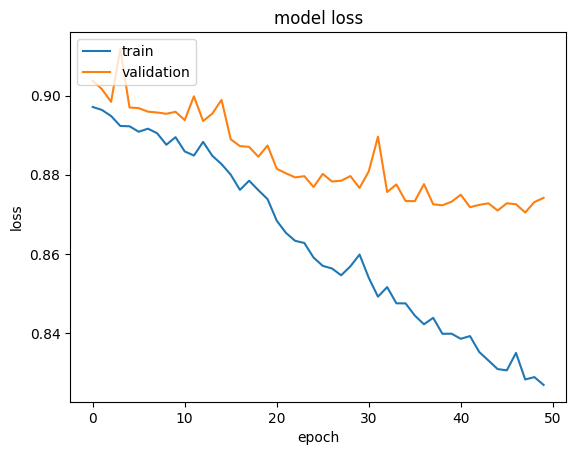

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [26]:
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

174/174 - 1s - loss: 0.8562 - accuracy: 0.6309 - 772ms/epoch - 4ms/step
Restored model, accuracy: 63.09%
